In [1]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
import mylib
from tqdm import tqdm
from importlib import reload
import pymaster as nmt
import mylib
import scipy as sp
import camb

In [2]:
def get_camb(Alens, r, lmax):
    pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
    pars.Alens = Alens
    if r != 0:
        pars.WantTensors=True
        pars.InitPower.set_params(r=r)
    results = camb.get_results(pars)
    return results.get_total_cls(lmax, 'muK', True).T

In [3]:
nside = 128
lmax = 3*nside - 1
npix = 12 * nside**2

input_cls = get_camb(1, 0, lmax)

input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

4.40673828125


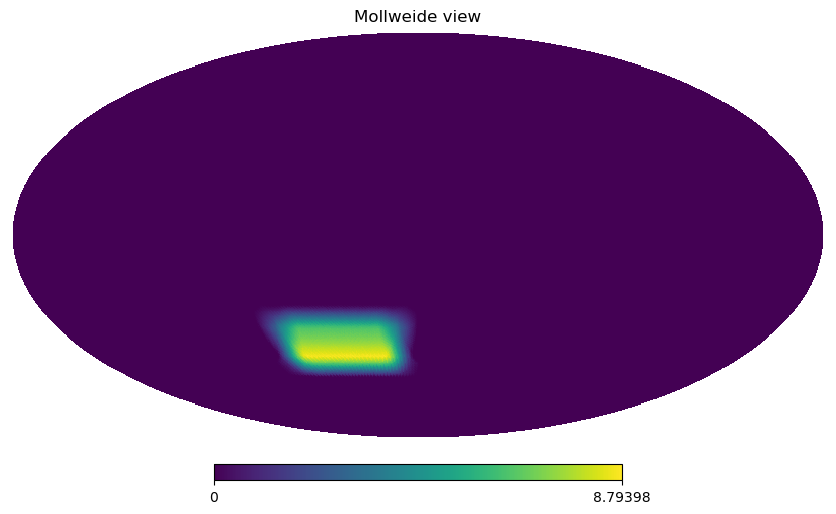

In [4]:
qq, qu, uu = hp.read_map(f'obsmat_nside{nside}/out/0/filterbin_invcov.fits', field=[3,4,5])
mask = np.zeros(npix)
mask[qq!=0] = 1
tr = qq + uu
det = qq * uu - qu * qu
weight = 0.5 * (tr - np.sqrt(tr ** 2 - 4 * det) ) 

mask_apo = nmt.mask_apodization(weight, 2, 'C2')
mask_apo /= np.sqrt(np.mean(mask_apo**2)) 

hp.mollview(mask_apo)
fsky = len(mask[mask!=0])/npix
print(fsky*100)

w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)

R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])
R = ZZ @ R_unapo

pi_b = sp.sparse.load_npz(f'pi_b_3000.npz')

In [5]:
reload(mylib)
bin_size = 16
b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
l = np.arange(lmax+1)
c2d = l * (l+1) / 2/np.pi
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
bl = hp.gauss_beam(fwhm, lmax) 
mll_KS = mylib.get_mll(mask_apo, nside, b, pol=True, purify_b=True)[2::4,2::4]
mll = mylib.get_mll(mask_apo, nside, b, pol=True)[2::4,2::4]
mll_scalar = mylib.get_mll(mask_apo, nside, b)

In [6]:
#filter transfer
# nmc_transfer = 512

# pcl = np.zeros(lmax+1)
# pcl_pure = np.zeros(lmax+1)
# pcl_KS = np.zeros(lmax+1)
# pcl_scalar = np.zeros(lmax+1)

# for i in tqdm(range(nmc_transfer)):
#     np.random.seed(i+1000)
#     m = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
#     obs_m_unapo = (R_unapo @ m.flatten()).reshape(3, npix) 
#     obs_m = mask_apo * obs_m_unapo
    
    # pcl += hp.anafast(obs_m)[2]

    # f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:], purify_b=True)
    # pcl_KS += nmt.compute_coupled_cell(f, f)[3]

    # B_map_unapo = hp.alm2map(hp.map2alm(obs_m_unapo)[2], nside)
    # pcl_scalar += hp.anafast(mask_apo * B_map_unapo)

    # obs_m[1:] = (pi_b @ (mask_apo*obs_m_unapo)[1:].flatten()).reshape(2, npix)
    # pcl_pure += hp.anafast(obs_m)[2]
    
# pcl /= nmc_transfer
# pcl_KS /= nmc_transfer
# pcl_scalar /= nmc_transfer
# pcl_pure /= nmc_transfer

# np.save('pcl', pcl)
# np.save('pcl_KS', pcl_KS)
# np.save('pcl_scalar', pcl_scalar)
# np.save('pcl_pure', pcl_pure)

pcl = np.load('pcl.npy')
pcl_KS = np.load('pcl_KS.npy')
pcl_scalar = np.load('pcl_scalar.npy')
pcl_pure = np.load('pcl_pure.npy')

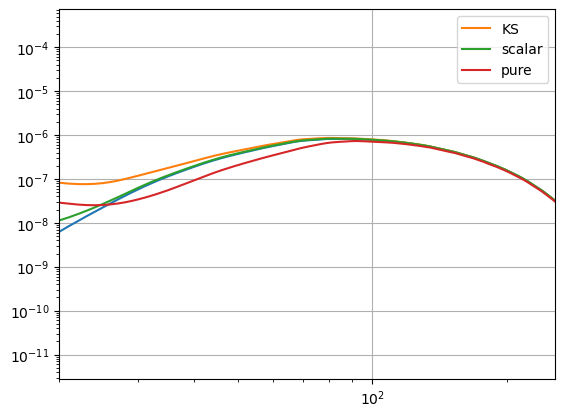

In [7]:
plt.plot(pcl)
plt.plot(pcl_KS, label='KS')
plt.plot(pcl_scalar, label='scalar')
plt.plot(pcl_pure, label='pure')
plt.xlim([20, 2*nside])
plt.loglog()
plt.grid()
plt.legend()

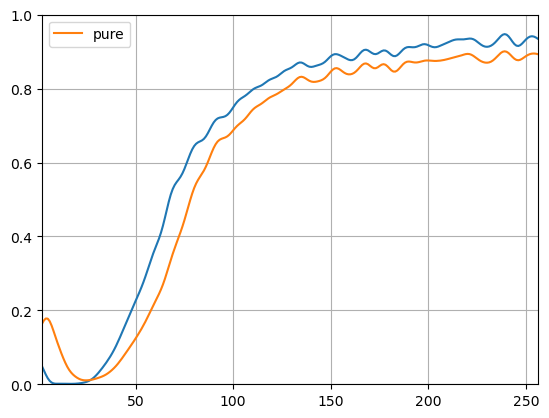

In [135]:
reload(mylib)
fl = mylib.get_fl(pcl, bl, mll, input_cls[2], niter=3)
fl_KS = mylib.get_fl(pcl_KS, bl, mll_KS, input_cls[2], niter=3)
fl_scalar = mylib.get_fl(pcl_scalar, bl, mll_scalar, input_cls[2], niter=3)
fl_pure = mylib.get_fl(pcl_pure, bl, mll, input_cls[2], niter=3)

# plt.plot(fl)
# plt.plot(fl_KS)
plt.plot(fl_scalar)
plt.plot(fl_pure, label='pure')
plt.xlim([2, 2*nside])
plt.ylim([0,1])
plt.grid()
plt.legend()

In [112]:
# prefix='S4'
prefix='SO_opt'
nmc_noise = 256

# cl_noise = np.zeros((6, lmax+1))
# cl_noise_KS_pol = np.zeros((4, lmax+1))
# cl_noise_scalar = np.zeros(lmax+1)
# cl_noise_pure = np.zeros((6, lmax+1))
# # cl_noise_pure = np.zeros((6, lmax+1))
# # nl = np.zeros((nmc_noise, len(ells)))

# for i in tqdm(range(nmc_noise)):
#     obs_noise_unapo = hp.read_map(f'{prefix}/out/{i+1000}/filterbin_filtered_map.fits', field=None)
#     obs_noise = mask_apo * obs_noise_unapo
    
    # cl_noise += hp.anafast(obs_noise)

    # f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:], purify_b=True)
    # cl_noise_KS_pol += nmt.compute_coupled_cell(f, f)

    # B_map_unapo = hp.alm2map(hp.map2alm(obs_noise_unapo)[2], nside)
    # cl_noise_scalar += hp.anafast(mask_apo * B_map_unapo)

    # obs_noise[1:] = (pi_b @ obs_noise[1:].flatten()).reshape(2, npix)
    # cl_noise_pure += hp.anafast(obs_noise)

    # f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:], beam=bl*np.sqrt(fl))
    # nl[i] = nmt.compute_full_master(f, f, b)[3]

# cl_noise /= nmc_noise
# cl_noise_pol = np.array([cl_noise[1], cl_noise[4], cl_noise[4], cl_noise[2]])
# cl_noise_KS_pol /= nmc_noise
# cl_noise_scalar /= nmc_noise
# cl_noise_pure /= nmc_noise
# cl_noise_pure_pol = np.array([cl_noise_pure[1], cl_noise_pure[4], cl_noise_pure[4], cl_noise_pure[2]])

# # mean_nl = np.mean(nl, axis=0)
# # std_nl = np.std(nl, axis=0)

# np.save(f'{prefix}_cl_noise_pol', cl_noise_pol)
# np.save(f'{prefix}_cl_noise_KS_pol', cl_noise_KS_pol)
# np.save(f'{prefix}_cl_noise_scalar', cl_noise_scalar)
# np.save(f'{prefix}_cl_noise_pure_pol', cl_noise_pure_pol)


cl_noise_pol = np.load(f'{prefix}_cl_noise_pol.npy')
cl_noise_KS_pol = np.load(f'{prefix}_cl_noise_KS_pol.npy')
cl_noise_scalar = np.load(f'{prefix}_cl_noise_scalar.npy')
cl_noise_pure_pol = np.load(f'{prefix}_cl_noise_pure_pol.npy')

(20, 256)

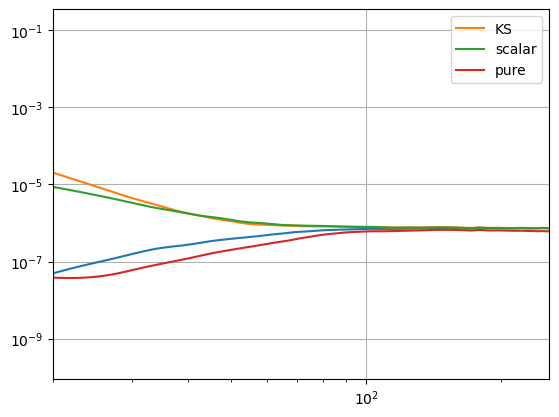

In [113]:
plt.plot(cl_noise_pol[3])
plt.plot(cl_noise_KS_pol[3], label='KS')
plt.plot(cl_noise_scalar, label='scalar')
plt.plot(cl_noise_pure_pol[3], label='pure')
plt.loglog()
plt.grid()
plt.legend()
plt.xlim([20, 2*nside])

In [114]:
#roughly by eye

planck_T_noise_props = [25, 50, -1.8]
planck_P_noise_props = [50, 20, -1.4]
planck_T = mylib.get_Nl(planck_T_noise_props, lmax)/bl**2
planck_P = mylib.get_Nl(planck_P_noise_props, lmax)/bl**2
planck_noise_cls = np.array([planck_T, planck_P, planck_P, np.zeros(lmax+1)])

lb_T_noise_props = [1.8, 5, -1] 
lb_P_noise_props = [2.16, 5, -1] 
lb_T = mylib.get_Nl(lb_T_noise_props, lmax)/bl**2
lb_P = mylib.get_Nl(lb_P_noise_props, lmax)/bl**2
lb_noise_cls = np.array([lb_T, lb_P, lb_P, np.zeros(lmax+1)])

# # sat_pol_baseline = mylib.get_Nl([np.sqrt(2)*3.3, 50, -3], lmax)/bl**2
# # sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 25, -3], lmax)/bl**2
# sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 50, -3], lmax)/bl**2

# s4 = mylib.get_Nl([1, 50, -2], lmax)/bl**2

# plt.errorbar(ells, c2db*mean_nl, yerr=c2db*std_nl, fmt='.', label='Nl_bb')
# plt.plot(c2d*s4, label='s4')
# # plt.plot(c2d*sat_pol_baseline, label='sat pol baseline')
# plt.plot(c2d*sat_pol_optimal, label='sat pol optimal')

# # plt.plot(c2d*planck_T, label='planck T')
# plt.plot(c2d*planck_P, label='planck P')

# # plt.plot(c2d*lb_T, label='lb T')
# plt.plot(c2d*lb_P, label='lb P')

# # plt.plot(c2d*input_cls[1])

# plt.legend()
# plt.loglog()
# plt.grid()
# plt.xlim([40, 2*nside])

In [115]:
w_scalar = nmt.NmtWorkspace()
f_scalar = nmt.NmtField(mask_apo, np.empty((1, npix)), beam=bl*np.sqrt(fl_scalar))
w_scalar.compute_coupling_matrix(f_scalar, f_scalar, b)
bpw_scalar = w_scalar.get_bandpower_windows()[0, :, 0]

w_KS = nmt.NmtWorkspace()
f_KS = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_KS), purify_b=True)
w_KS.compute_coupling_matrix(f_KS, f_KS, b)
bpw_KS = w_KS.get_bandpower_windows()[3, :, 3]

w_pure = nmt.NmtWorkspace()
f_pure = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_pure), masked_on_input=True)
w_pure.compute_coupling_matrix(f_pure, f_pure, b)
bpw_pure = w_pure.get_bandpower_windows()[3, :, 3]

In [147]:
nmc = 50
    
cl_KS = np.empty((nmc, len(ells)))
cl_matpure = np.empty((nmc, len(ells)))
cl_KS_planck = np.empty((nmc, len(ells)))
cl_KS_lb = np.empty((nmc, len(ells)))
cl_KS_noiseless = np.empty((nmc, len(ells)))
cl_full_planck = np.empty((nmc, len(ells)))
cl_full_lb = np.empty((nmc, len(ells)))
cl_full_noiseless = np.empty((nmc, len(ells)))

for i in tqdm(range(nmc)):
    # signal 
    np.random.seed(i)
    # signal = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    # signal = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
    signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
    obs_signal_unapo = (R_unapo @ signal.flatten()).reshape(3, npix) 

    # noise 
    obs_noise_unapo = hp.read_map(f'{prefix}/out/{i+1000+nmc_noise}/filterbin_filtered_map.fits', field=None)

    #signal + noise
    obs_m_unapo = obs_signal_unapo + obs_noise_unapo

    #KS
    f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:], purify_b=True)
    # cl_KS[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]
    
    #matrix pure
    obs_m = mask_apo * obs_m_unapo #since purification was constructed to apply to apodized maps
    pure_QU = (pi_b @ obs_m[1:].flatten()).reshape(2, npix)
    f = nmt.NmtField(mask_apo, mask*pure_QU, masked_on_input=True)
    # cl_matpure[i] = nmt.compute_full_master(f, f, b, cl_noise_pure_pol, workspace=w_pure)[3]
    cl_matpure[i] = nmt.compute_full_master(f, f, b, workspace=w_pure)[3]

    #full planck
    np.random.seed(i+2000)
    planck_noise = hp.synfast(planck_noise_cls, nside, new=True)
    E_map = mylib.wiener_filter(signal + planck_noise, input_cls, planck_noise_cls)
    observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
    restored_map = obs_m_unapo + E_map - observed_E_map
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # cl_full_planck[i] = nmt.compute_full_master(f, f, b, [cl_noise_scalar], workspace=w_scalar)[0]
    cl_full_planck[i] = nmt.compute_full_master(f, f, b, workspace=w_scalar)[0]
    
    #KS Planck
    f = nmt.NmtField(mask_apo, mask*restored_map[1:], purify_b=True)
    # cl_KS_planck[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS_planck[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

    #full lb
    np.random.seed(i+3000)
    lb_noise = hp.synfast(lb_noise_cls, nside, new=True)
    E_map = mylib.wiener_filter(signal + lb_noise, input_cls, lb_noise_cls)
    observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
    restored_map = obs_m_unapo + E_map - observed_E_map
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # cl_full_lb[i] = nmt.compute_full_master(f, f, b, [cl_noise_scalar], workspace=w_scalar)[0]
    cl_full_lb[i] = nmt.compute_full_master(f, f, b, workspace=w_scalar)[0]

    #KS lb
    f = nmt.NmtField(mask_apo, mask*restored_map[1:], purify_b=True)
    # cl_KS_lb[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS_lb[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

    #full noiseless
    E_map = signal
    observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
    restored_map = obs_m_unapo + E_map - observed_E_map
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # cl_full_noiseless[i] = nmt.compute_full_master(f, f, b, [cl_noise_scalar], workspace=w_scalar)[0]
    cl_full_noiseless[i] = nmt.compute_full_master(f, f, b, workspace=w_scalar)[0]

    #KS noiseless
    f = nmt.NmtField(mask_apo, mask*restored_map[1:], purify_b=True)
    # cl_KS_noiseless[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS_noiseless[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

mean_KS = c2db * np.mean(cl_KS, axis=0)
std_KS = c2db * np.std(cl_KS, axis=0)
      
mean_matpure = c2db * np.mean(cl_matpure, axis=0)
std_matpure = c2db * np.std(cl_matpure, axis=0)
      
mean_KS_planck = c2db * np.mean(cl_KS_planck, axis=0)
std_KS_planck = c2db * np.std(cl_KS_planck, axis=0)

mean_KS_lb = c2db * np.mean(cl_KS_lb, axis=0)
std_KS_lb = c2db * np.std(cl_KS_lb, axis=0)

mean_KS_noiseless = c2db * np.mean(cl_KS_noiseless, axis=0)
std_KS_noiseless = c2db * np.std(cl_KS_noiseless, axis=0)

mean_full_planck = c2db * np.mean(cl_full_planck, axis=0)
std_full_planck = c2db * np.std(cl_full_planck, axis=0)

mean_full_lb = c2db * np.mean(cl_full_lb, axis=0)
std_full_lb = c2db * np.std(cl_full_lb, axis=0)

mean_full_noiseless = c2db * np.mean(cl_full_noiseless, axis=0)
std_full_noiseless = c2db * np.std(cl_full_noiseless, axis=0)

100%|███████████████████████████████████████████████████████████████████| 50/50 [04:45<00:00,  5.70s/it]


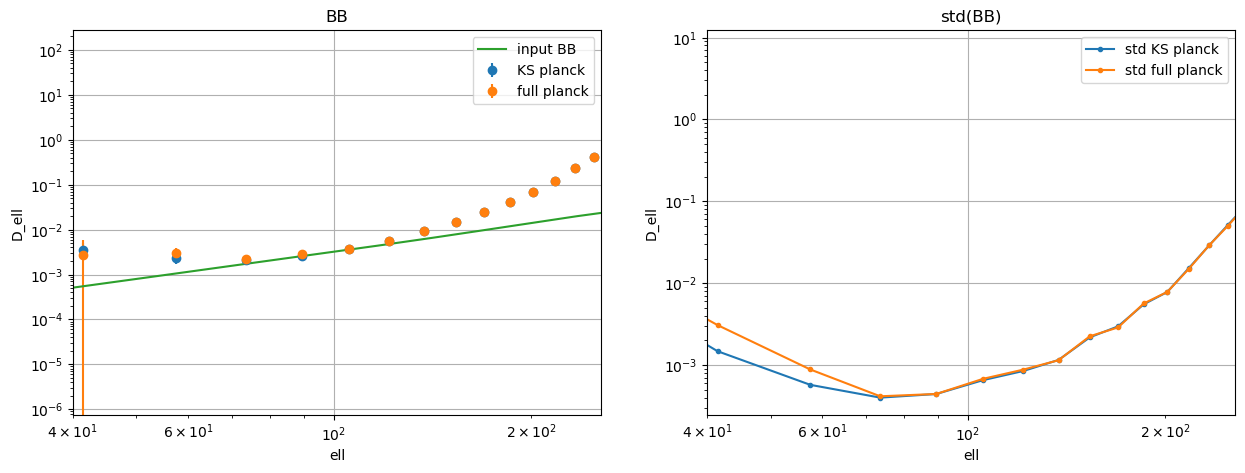

In [160]:
# nu_l = (2*l+1)*fsky*w2**2/w4*bin_size*fl
# knox = (bpw@input_cls[2] + mean_nl) * np.sqrt(2/(bpw@nu_l))
# # knox = (bpw@input_cls[2]) * np.sqrt(2/(bpw@nu_l))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# axes[0].errorbar(ells, mean_KS, yerr=std_KS, fmt='o', label='KS')
# axes[0].errorbar(ells, mean_matpure, yerr=std_matpure, fmt='o', label='matpure')
axes[0].errorbar(ells, mean_KS_planck, yerr=std_KS_planck, fmt='o', label='KS planck')
# axes[0].errorbar(ells, mean_KS_lb, yerr=std_KS_lb, fmt='o', label='KS lb')
# axes[0].errorbar(ells, mean_KS_noiseless, yerr=std_KS_noiseless, fmt='o', label='KS noiseless')
axes[0].errorbar(ells, mean_full_planck, yerr=std_full_planck, fmt='o', label='full planck')
# axes[0].errorbar(ells, mean_full_lb, yerr=std_full_lb, fmt='o', label='full lb')
# axes[0].errorbar(ells, mean_full_noiseless, yerr=std_full_noiseless, fmt='o', label='full noiseless')

axes[0].plot(c2d * input_cls[2], label='input BB')

# axes[0].plot(c2d*cl_noise_pure_pol[3], label='residual noise matpure', linestyle='dashed')
# axes[0].plot(c2d*cl_noise_KS_pol[3], label='residual noise KS', linestyle='dashed')
# axes[0].plot(c2d*cl_noise_scalar, label='residual noise scalar', linestyle='dashed')

axes[0].set_title('BB')
# axes[0].set_ylim([1e-5, 1e-1])

# axes[1].plot(ells, std_KS, marker='.',label='std KS')
# axes[1].plot(ells, std_matpure, marker='.',label='std matpure')
axes[1].plot(ells, std_KS_planck, marker='.',label='std KS planck')
# axes[1].plot(ells, std_KS_lb, marker='.',label='std KS lb')
# axes[1].plot(ells, std_KS_noiseless, marker='.',label='std KS noiseless')
axes[1].plot(ells, std_full_planck, marker='.',label='std full planck')
# axes[1].plot(ells, std_full_lb, marker='.',label='std full lb')
# axes[1].plot(ells, std_full_noiseless, marker='.',label='std full noiseless')
# axes[1].plot(ells, c2db*knox, label='knox')
axes[1].set_title('std(BB)')
# axes[1].set_ylim([1e-4, 1e-2])

for ax in axes.flatten():
    ax.legend()
    ax.set_xlim([40, 2*nside])
    # ax.set_ylim([1e-5, 1e-1])
    ax.loglog()
    ax.grid()
    ax.set_xlabel('ell')
    ax.set_ylabel('D_ell')

In [149]:
# signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
# obs_m_unapo = (R_unapo @ signal.flatten()).reshape(3, npix) 
# obs_m = mask_apo * obs_m_unapo
# noise = hp.synfast(planck_noise_cls, nside, new=True)
# E_map = mylib.wiener_filter(signal + noise, input_cls, planck_noise_cls)

In [150]:
# # plt.plot(hp.anafast(obs_m)[2])

# B_map = hp.alm2map(hp.map2alm(obs_m_unapo)[2], nside)
# plt.plot(hp.anafast(mask_apo*B_map))

# f = nmt.NmtField(mask_apo, [B_map], masked_on_input=False)
# plt.plot(nmt.compute_coupled_cell(f, f)[0], label='nmt')

# # observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
# # restored_map = obs_m_unapo + E_map - observed_E_map
# # B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
# # plt.plot(hp.anafast(mask_apo * B_map), label='unapo')

# # observed_E_map = (R @ E_map.flatten()).reshape(3, npix)
# # restored_map = obs_m + E_map - observed_E_map
# # B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
# # plt.plot(hp.anafast(B_map), label='apo')

# plt.loglog()
# plt.legend()
# plt.xlim([20, 2*nside])

In [151]:
# # f = nmt.NmtField(mask_apo, [B_map], masked_on_input=True)
# # plt.plot(ells, nmt.compute_full_master(f, f, b)[0], label='B_map')

# un_B_map = hp.alm2map(hp.map2alm(obs_m)[2], nside)
# f = nmt.NmtField(mask_apo, [un_B_map], masked_on_input=True)
# plt.plot(ells, nmt.compute_full_master(f, f, b)[0], label='un_B_map')

# f = nmt.NmtField(mask_apo, obs_m[1:], masked_on_input=True)
# plt.plot(ells, nmt.compute_full_master(f, f, b)[3], label='obs_m')

# plt.loglog()
# plt.legend()
# plt.xlim([20, 2*nside])

In [152]:
# f = nmt.NmtField(mask_apo, obs_m_unapo[1:], purify_b=True, masked_on_input=False)
# plt.plot(ells, nmt.compute_full_master(f, f, b)[3])

# observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
# restored_map = obs_m_unapo + E_map - observed_E_map
# B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
# f = nmt.NmtField(mask_apo, [B_map], masked_on_input=False)
# plt.plot(ells, nmt.compute_full_master(f, f, b)[0], label='unapo')

# observed_E_map = (R @ E_map.flatten()).reshape(3, npix)
# restored_map = obs_m + E_map - observed_E_map
# B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
# f = nmt.NmtField(mask_apo, [B_map], masked_on_input=True)
# plt.plot(ells, nmt.compute_full_master(f, f, b)[0], label='apo')

# plt.loglog()
# plt.legend()
# plt.xlim([20, 2*nside])

In [153]:
cl_r1 = get_camb(0, 1, lmax) 

In [154]:
ell_min = 40
ell_max = 2*nside
inds = (ells >=ell_min) & (ells <= ell_max)

sigma_r_KS = np.zeros(nmc)
sigma_r_matpure = np.zeros(nmc)
sigma_r_KS_planck = np.zeros(nmc)
sigma_r_KS_lb = np.zeros(nmc)
sigma_r_KS_noiseless = np.zeros(nmc)

sigma_r_full_planck = np.zeros(nmc)
sigma_r_full_lb = np.zeros(nmc)
sigma_r_full_noiseless = np.zeros(nmc)

for i in range(nmc):
    sigma_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS[i][inds])**2 )) 
    sigma_r_KS_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS_planck[i][inds])**2 )) 
    sigma_r_KS_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS_lb[i][inds])**2 ))     
    sigma_r_KS_noiseless[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS_noiseless[i][inds])**2 )) 
    sigma_r_matpure[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_pure@cl_r1[2])[inds] / cl_matpure[i][inds])**2 )) 
    sigma_r_full_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_scalar@cl_r1[2])[inds] / cl_full_planck[i][inds])**2 )) 
    sigma_r_full_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_scalar@cl_r1[2])[inds] / cl_full_lb[i][inds])**2 ))     
    sigma_r_full_noiseless[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_scalar@cl_r1[2])[inds] / cl_full_noiseless[i][inds])**2 ))


Text(0, 0.5, '# MC')

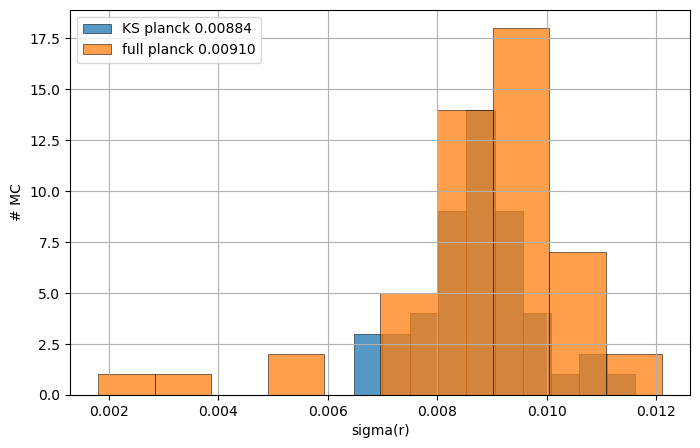

In [161]:
plt.figure(figsize=(8,5))
# plt.hist(sigma_r_KS, label=f'KS {np.median(sigma_r_KS):.5f}', alpha=0.75, edgecolor='black', linewidth=0.5)
plt.hist(sigma_r_KS_planck, label=f'KS planck {np.median(sigma_r_KS_planck):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_KS_lb, label=f'KS lb {np.median(sigma_r_KS_lb):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_KS_noiseless, label=f'KS noiseless {np.median(sigma_r_KS_noiseless):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
plt.hist(sigma_r_full_planck, label=f'full planck {np.median(sigma_r_full_planck):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_full_lb, label=f'full lb {np.median(sigma_r_full_lb):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_full_noiseless, label=f'full noiseless {np.median(sigma_r_full_noiseless):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_matpure, label=f'matpure {np.median(sigma_r_matpure):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)

plt.legend()
plt.grid()
plt.xlabel('sigma(r)')
plt.ylabel('# MC')
# plt.semilogx()